# Analyze A/B Test Results 

 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. Goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.





<a id='probability'></a>
## Part I - Probability



In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [6]:
df.converted.value_counts(normalize=True)

0    0.880341
1    0.119659
Name: converted, dtype: float64

In [7]:
df[df['converted']==1].shape[0]/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
x=df.query('group == "treatment" and landing_page == "old_page"').shape

y=df.query('group == "control" and landing_page == "new_page"').shape
x[0]+y[0]

3893

**f.** Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB



In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



In [20]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.query('group == "treatment" and landing_page == "new_page"')
df2=df2.append(df.query('group == "control" and landing_page == "old_page"'))




In [21]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [22]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [23]:
df2['user_id'].value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [24]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [25]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not

df2.drop(index=1899,axis=0,inplace=True)




In [26]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0



**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [27]:
tot_conversions = df2.query('converted==1')['user_id'].nunique() 
tot_visitors = df2.shape[0] 
tot_conversions / tot_visitors 

0.11959708724499628

$p_{population}$ = 0.11959

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [28]:
tot_Control_members=df2.query('group=="control"')['user_id'].shape[0]

tot_control_conversions=df2.query('group=="control" and converted==1')['user_id'].nunique() 

a = tot_control_conversions/tot_Control_members

a


0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [29]:
tot_Treatment_members=df2.query('group=="treatment"')['user_id'].shape[0]

tot_treat_conversions=df2.query('group=="treatment" and converted==1')['user_id'].nunique() 

b = tot_treat_conversions/tot_Treatment_members
b

0.11880806551510564

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [30]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff=b-a
obs_diff


-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [31]:
#number of ppl landing on new page / tot_number_visitors
df2.query('landing_page=="new_page"')['user_id'].nunique()/tot_visitors

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Probability of old page conversions are slightly more than new page conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**H0: Null states that conversion probabilities for old page and new page are similar                                                      
H1: Alternative state that new page has better conversions than old page.**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [32]:
tot_conversions = df2.query('converted==1')['user_id'].nunique() 
tot_visitors = df2.shape[0] 
p_new=tot_conversions / tot_visitors 

**Under null, conversion rate for new page and old page is same hence  Pnew = Pold = 0.119**

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [33]:
p_old=p_new

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [34]:
n_new=df2[df2['landing_page']=="new_page"].shape[0]

**d.** What is $n_{old}$, the number of individuals in the control group?

In [36]:
n_old=df2[df2['landing_page']=="old_page"].shape[0]

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [37]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted.mean()

0.11981969582272384

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [38]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
old_page_converted.mean()


0.11977366906672908

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [39]:
new_page_converted.mean()-old_page_converted.mean()

4.6026755994757473e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [40]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
    
    

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

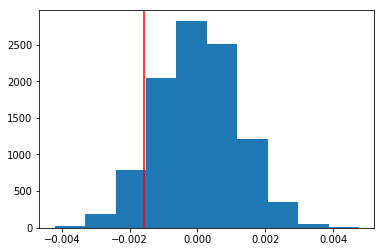

In [41]:
 
plt.hist(p_diffs)
actual_diff = (df2.query('group == "treatment" & converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]) - \
df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]
plt.axvline(x=actual_diff, color='red');
plt.show()


**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [42]:
p_diffs=np.array(p_diffs)
(p_diffs>obs_diff).mean()

0.90849999999999997

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**We calculate p value which is 0.9. This P value suggests that there there is evidence to support null which means conversion rates are same for new and old pages.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [43]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1')['user_id'].nunique()

# number of conversions with the new_page
convert_new =df2.query('landing_page == "new_page" and converted == 1')['user_id'].nunique()


# number of individuals who were shown the old_page
n_old =  df2.query('landing_page == "old_page"')['user_id'].nunique()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [44]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Higher P value suggests that there is no statistical difference in conversion rates for both groups and fail to reject null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logical Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [45]:

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [46]:
import statsmodels.api as sm
df2['intercept']=1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-25 18:38 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**NULL H0 IN REGRESSION: Explanatory variables are not statistically significant in explaining Response.
                                                                       ALTERNATE H1 IN Regression : Explanatory variables are statistically significant in explaining Response.
                                                                        Since p value in Regression(0.189)  > 0.05, we have enough evidence to accept Null. This means that conversion rate cant just be explained by which page the user lands in.**

>**NULL H0 IN DIFFERENCE OF PROPORTIONS: is that conversion is same for both Old page or new page.
ALTERNATE H1 IN DIFFERENCE OF PROPORTIONS: is that new page has more conversions than old page
P value for this part was 0.9 > 0.05 suggests that conversion rates are similar for both groups.** 
 


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Since Landing page was not statistically significant in determing the conversion rate its a good idea to include other factors in regression model**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [48]:
# Read the countries.csv
countries=pd.read_csv('countries.csv')
countries.set_index('user_id',inplace=True);
df2.set_index('user_id',inplace=True);

In [49]:
# Join with the df2 dataframe
df3=df2.join(countries,on='user_id',how='inner',lsuffix='_df2',rsuffix='_country')
df3.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [50]:
# Create the necessary dummy variables
df3[['CA','UK','US']]=pd.get_dummies(df3['country'])
df3=df3.drop('CA',axis=1)
df3.head()
lm2=sm.Logit(df3['converted'],df3[['intercept','UK','US']]) 
results=lm2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-25 18:38 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

>**P-values is higher for UK and US , which suggests that we have enough statistical evidence to support null hypothesis. Countries are not statistically significant in explaining conversions
.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [51]:
# Fit your model, and summarize the results
df3['UK_page_interaction']=df3['ab_page']*df3['UK']
df3['US_page_interaction']=df3['ab_page']*df3['US']
lm4=sm.Logit(df3['converted'],df3[['intercept','UK','US','UK_page_interaction','US_page_interaction']])
results=lm4.fit()
results.summary2()


Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            No. Iterations:   6.0000     
Dependent Variable:   converted        Pseudo R-squared: 0.000      
Date:                 2022-05-25 18:38 AIC:              212782.3422
No. Observations:     290584           BIC:              212835.2404
Df Model:             4                Log-Likelihood:   -1.0639e+05
Df Residuals:         290579           LL-Null:          -1.0639e+05
Converged:            1.0000           Scale:            1.0000     
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept           -2.0375   0.0260 -78.3639 0.0000 -2.0885 -1.9866
UK                   0.0453   0.0306   1.4806 0.1387 -0.0147  0.1053
US                   0.0511   0.0277   1.8414 0.0656 -0.0033  0.1054
UK_page_interaction  0.0108   0.0228   0.4749 0.6349 -0.0339  0.0555
US_page_interaction -0.0206   0.0137  -1.5052 0.1323 -0.0473  0.0062
====================================================================

"""

>**P values are higher for interaction terms which means Null Hypothesis is true.There is no statistical significance that page or country has on conversion.We can conclude that old version works fine and no need to make implment new one**

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0